In [1]:
from Bessel import * 
import resonanzen as rs 
from roots_y import *
from tracing import *
import bound_states as bs
import numpy as np
import matplotlib.pyplot as plt
import os
import tableReading


%load_ext autoreload

In [ ]:
%autoreload 2

# für nachfolgende Zellen benutze Parameter zur Erzeugung von Tabellen und Plots
max_y = 16
max_v0 = 400000
max_l = 10
init_y = 1e-12

def save_table(type, l, linenumber, trace_x, trace_y, trace_v0):
    '''Speicherungsprozess der Tabellen'''
    directory = f"tables/l={l}"
    filename = tableReading.f_name(type, l, linenumber)

    if not os.path.exists(directory):
        os.makedirs(directory)

    np.savetxt(
        filename,
        np.column_stack((trace_x, trace_y, trace_v0)),
        header = "x, y, v0",
        delimiter = ",")

Berechne 1. Werte neue gebundene Zustände mit Fehler (2 unabhängige Fehler)

In [ ]:
%autoreload 2

v0_step   = lambda v0: 0.05*(0.005 * v0 + 2)
TOLERANCE = 1e-12          # numerische Toleranz

for l in range(max_l + 1): 
    l_bound_states     = lambda y, v0: bs.bound_states(l, y, v0)
    l_bound_states_dv0 = lambda y, v0: bs.bound_states_dv0(l, y, v0) 
    l_bound_states_dy  = lambda y, v0: bs.bound_states_dy(l, y, v0)   

    # Bound States im Niederenergielimit finden
    y0 = init_y
    roots = roots_y(l_bound_states, l_bound_states_dv0, y0, 0, max_v0, v0_step)
    v0_first = np.array(roots, dtype=float)

    # x- und y-Arrays
    y = np.full(len(v0_first), y0, dtype=float)
    x = bs.to_x(y, v0_first)

    # Fehlerberechnung entsprechend der Erläuterung in der Bachelorarbeit
    Fy_list  = [l_bound_states_dy(y0, v0)  for v0 in v0_first]
    Fv0_list = [l_bound_states_dv0(y0, v0) for v0 in v0_first]
    Fy  = np.asarray(Fy_list, dtype=float)
    Fv0 = np.asarray(Fv0_list, dtype=float)

    # Schutz gegen Division durch sehr kleine Fv0
    eps = 1e-300
    Fv0_safe = np.where(np.abs(Fv0) > eps, Fv0, np.sign(Fv0) * eps)

    sigma_v0_lim = np.abs(Fy / Fv0_safe) * init_y
    sigma_v0 = np.abs(sigma_v0_lim) + np.abs(TOLERANCE)

    # Datenspeicherung in Tabelle
    ordner = f"tables/l={l}"
    os.makedirs(ordner, exist_ok=True)
    dateiname = os.path.join(ordner, f"neue_Boundstates_l={l}_mit_Fehler.csv")

    header = "x,y,v0_first,sigma_v0"
    data = np.column_stack((x, y, v0_first, sigma_v0))
    np.savetxt(dateiname, data, delimiter=",", header=header, comments='')

    print(f"Datei gespeichert als: {dateiname}")

Berechne 1. Werte neue Resonanz mit Fehler (2 unabhängige Fehler)

In [ ]:
%autoreload 2

v0_step= lambda v0: 0.05 * (0.005 * v0 + 2)
TOLERANCE = 1e-12                 

for l in range(max_l + 1): 
    l_denominator      = lambda y, v0: rs.denominator(y, v0, l)
    l_denominator_dv0  = lambda y, v0: rs.denominator_dv0(y, v0, l) 
    l_denominator_dy   = lambda y, v0: rs.denominator_dy(y, v0, l)   

    # Resonanzen im Niederenergielimit finden
    y0 = init_y
    roots = roots_y(l_denominator, l_denominator_dv0, y0, 0, max_v0, v0_step)
    v0_first = np.array(roots, dtype=float)

    # x- und y-Arrays
    y = np.full(len(v0_first), y0, dtype=float)
    x = rs.to_x(y, v0_first)

    # Fehlerberechnung entsprechend der Erläuterung in der Bachelorarbeit
    Fy_list  = [l_denominator_dy(y0, v0)  for v0 in v0_first]
    Fv0_list = [l_denominator_dv0(y0, v0) for v0 in v0_first]
    Fy  = np.asarray(Fy_list, dtype=float)
    Fv0 = np.asarray(Fv0_list, dtype=float)

    # Schutz gegen Division durch sehr kleine Fv0
    eps = 1e-300
    Fv0_safe = np.where(np.abs(Fv0) > eps, Fv0, np.sign(Fv0) * eps)

    sigma_v0_lim = np.abs(Fy / Fv0_safe) * init_y
    sigma_v0 = np.abs(sigma_v0_lim) + np.abs(TOLERANCE)

    # Datenspeicherung in Tabelle
    ordner = f"tables/l={l}"
    os.makedirs(ordner, exist_ok=True)
    dateiname = os.path.join(ordner, f"neue_Resonanzen_l={l}_mit_Fehler.csv")

    header = "x,y,v0_first,sigma_v0"
    data = np.column_stack((x, y, v0_first, sigma_v0))
    np.savetxt(dateiname, data, delimiter=",", header=header, comments='')

    print(f"Datei gespeichert als: {dateiname}")

Berechne Werte neue Resonanz für $y_{min}$ bei dem Tiefpunkt in $v_0$
(Werte der Tiefpunkte in $v_0$ bei nicht-monotonem Resonanzverhalten für höhere Ordnungen)

In [ ]:
%autoreload 2
v0_step= lambda v0: 0.05 * (0.0005 * v0 + 2)
y_step=0.005

for l in range(max_l+1): 
    l_denominator = lambda y, v0: rs.denominator(y, v0, l)
    l_denominator_dv0 = lambda y, v0: rs.denominator_dv0(y, v0, l)

    all_roots = []
    if l == 0: 
        y = init_y
    else:
        y = tableReading.find_ymin_for_min_v0(l)
    roots = roots_y(l_denominator, l_denominator_dv0, y, 0, max_v0, v0_step)   
    v0_first= np.array(roots)
    y = np.ones(len(roots)) * y
    x = rs.to_x(y, v0_first)

    ordner = f"tables/l={l}"
    dateiname = os.path.join(ordner, f"min_v0_Resonanzen_l={l}.csv")

    header = "x,y,v0_first"
    data = np.column_stack((x, y, v0_first))
    np.savetxt(dateiname, data, delimiter=",", header=header, comments='')

    print(f"Datei gespeichert als: {dateiname}")

Berechne Tabellen für Resonanzen mit trace_root

In [ ]:
%autoreload 2

v0_step= lambda v0: 0.005 * v0 + 2
for l in range(max_l+1):
    l_denominator = lambda y, v0: rs.denominator(y, v0, l)
    l_denominator_dv0 = lambda y, v0: rs.denominator_dv0(y, v0, l)
    l_denominator_dy = lambda y, v0: rs.denominator_dy(y, v0, l)

    # Resonanzen im Niederenergielimit finden
    roots = roots_y(l_denominator, l_denominator_dv0, init_y, 0, max_v0, v0_step)

    for i, ry in enumerate(roots):
        # Schreiben von roots_x und roots_y in tracey und tracev0 
        tracey, tracev0= trace_root(init_y, ry, l_denominator, l_denominator_dy, l_denominator_dv0, max_y)      
        tracex = rs.to_x(tracey, tracev0)
        min_pos = np.argmin(tracev0)
        min_v0 = tracev0[min_pos]

        save_table("Resonanzen", l, i, tracex, tracey, tracev0)
        print(f"Finished l={l}, i={i}/{len(roots)}")

Berechne Tabellen für gebundene Zustände mit roots_y

In [ ]:
%autoreload 2
v0_step= lambda v0: 0.005 * v0 + 2
y_step=0.0005

for l in range(max_l+1): 
    l_bound_states = lambda y, v0: bs.bound_states(l, y, v0)
    l_bound_states_dv0 = lambda y, v0: bs.bound_states_dv0(l, y, v0)
    
    # Bound States im Niederenergielimit finden
    all_roots = []
    y = init_y
    roots = roots_y(l_bound_states, l_bound_states_dv0, y, 0, max_v0, v0_step)

    # Finde roots nahe y=0
    for r in roots:
        all_roots.append(([y], [r]))

    # finde die entsprechenden roots für y>0
    while y <= max_y:
        y+= y_step
        roots = roots_y(l_bound_states, l_bound_states_dv0, y, 0, max_v0, v0_step)
        for i, r in enumerate(roots):
            if i >= len(all_roots):
                all_roots.append(([],[]))
            ry, rv0 = all_roots[i]
            
            ry.append(y)
            rv0.append(r)
            
    # Speicherung der Daten in Tabellen 
    for i, (ry, rv0) in enumerate(all_roots):
        ry = np.array(ry)
        rv0 = np.array(rv0)
        rx = bs.to_x(ry, rv0)
        save_table("Bound States", l, i, rx, ry, rv0)
        print(f"Finished l={l}, i={i}/{len(all_roots)}")
    

Plots für alle relevanten Ordnungen von gebundenen Zuständen und Resonanzen

2.4674011133611202
7.402203302141306
12.359764204908
17.539600623218323
22.93838223996231
28.541200779565155
34.33327447069112
2.4676011062195498
9.86960443108736
20.190728573093295
33.21746192826837
Max. relevante Ordnung für Resonanzen: 6
Max. relevante Ordnung für Bound States: 3


C:\Users\josch\AppData\Local\Temp\ipykernel_24104\4091802305.py:74: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\josch\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


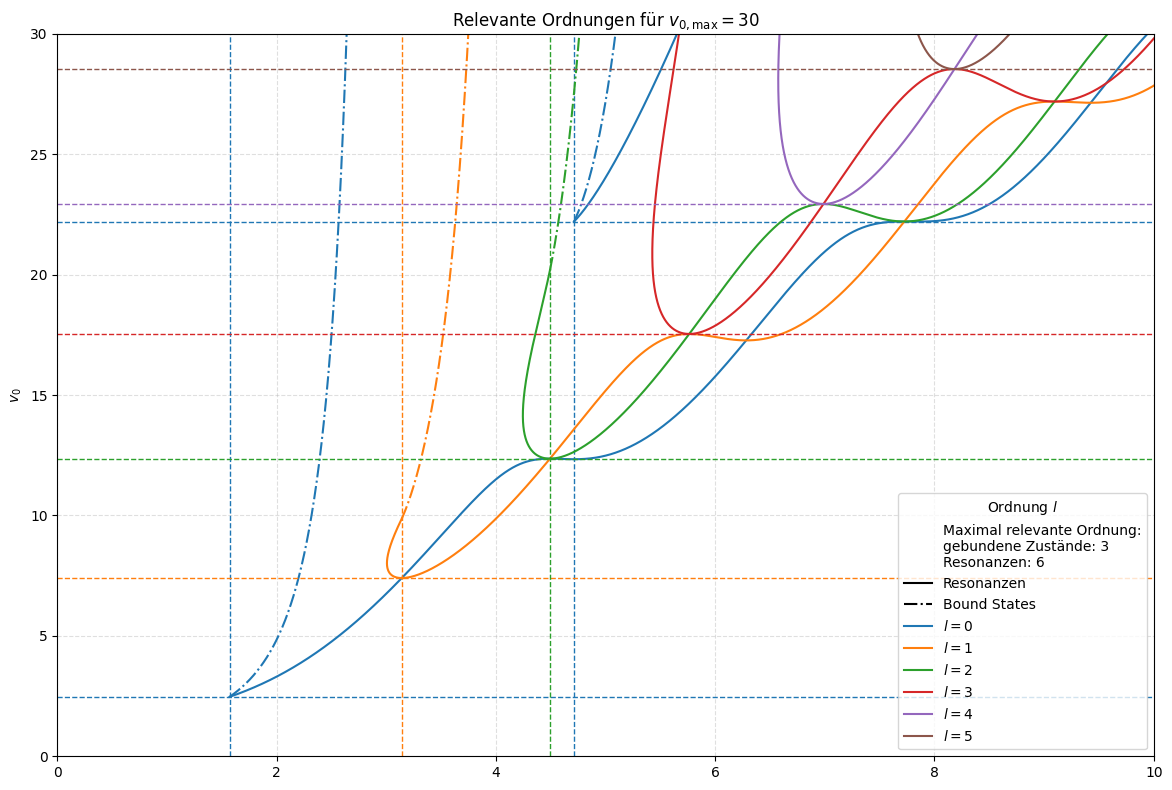

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
from matplotlib.lines import Line2D

%autoreload 2
# maximales v0 individuell zur Übersichtlichkeit und für gewünschten relevanten Bereichangeben
v0_max = 30

# Farbfestlegung
max_colors = 10
colormap = plt.cm.tab10
colorlist = [colormap(k / max_colors) for k in range(max_colors)]

plt.figure(figsize=(12, 8))
plt.xlabel = r'$x = \sqrt{y^2 + v_0}$ für Resonanzen,  $x = \sqrt{v_0 - y^2}$ für Bound States'
plt.ylabel(r'$v_0$')

# Listen für Legenden-Handles und -Labels
handles = []
labels = []

l = 0
max_l_rs = tableReading.check_max_l("Resonanzen", v0_max)
max_l_bs = tableReading.check_max_l("Bound States", v0_max)
print("Max. relevante Ordnung für Resonanzen:", max_l_rs)
print("Max. relevante Ordnung für Bound States:", max_l_bs)

# iteration über für v0 relevante Ordnungen
for l in range(0, max_l_rs):
    i = 0
    color = colorlist[l % max_colors]
    leg_label = f"$l={l}$"
    handle = None

    while os.path.isfile(tableReading.f_name("Resonanzen", l, i)):
        # Resonanzen auslesen
        x_rs, y_rs, v0_rs = tableReading.read_line_Resonanzen(l, i)
        p, = plt.plot(x_rs, v0_rs, '-', markersize=1, color=color)
        if handle is None:
            handle = p
        min_v0 = np.min(v0_rs)
        plt.axhline(min_v0, color=color, linestyle='--', linewidth=1)

        # Bound states auslesen
        if l <= max_l_bs:
            x_bs, y_bs, v0_bs = tableReading.read_line_Bound_States(l, i)
            plt.plot(x_bs, v0_bs, '-.', markersize=1, color=color)
            start_x = x_bs[0]
            if v0_bs[0] <= v0_max:
                plt.axvline(start_x, color=color, linestyle='--', linewidth=1)

        i += 1

    # ein Handle pro l in die Legende
    if handle is not None:
        handles.append(handle)
        labels.append(leg_label)

extra_text = f"Maximal relevante Ordnung:\ngebundene Zustände: {max_l_bs}\nResonanzen: {max_l_rs}"

# Handle für die textuelle Info
text_handle = Line2D([], [], color='none', label=extra_text)

# Handles für die Linienstile
res_handle = Line2D([0], [0], color="black", linestyle="-", label="Resonanzen")
bs_handle  = Line2D([0], [0], color="black", linestyle="-.", label="Bound States")

# Handles und Labels für die Legende kombiniert
handles = [text_handle, res_handle, bs_handle] + handles
labels = [extra_text, "Resonanzen", "Bound States"] + labels

plt.title(f"Relevante Ordnungen für $v_{{0,\\mathrm{{max}}}} = {v0_max}$")
plt.legend(handles, labels, title="Ordnung $l$")

plt.grid(True, which="both", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.xlim(0, v0_max/3)
plt.ylim(0, v0_max)
plt.show()
